# Import libraries

In [15]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"]="1"   
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Dropout, BatchNormalization, Input, Layer, Dense,LSTM, AveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy
from keras import initializers
from keras import metrics
from pandas_datareader import data
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC#Download data from the web via this package
import xgboost as xgb
import numpy as np
import talib
import matplotlib.pyplot as plt
%matplotlib inline 

In [5]:
import warnings
warnings.filterwarnings("ignore")
#warnings.filterwarnings("default")

# Traffic data

In [6]:
train = pd.read_csv('train.csv')
EB00=train[(train['x']==0) & (train['y']==0) & (train['direction']=='EB')].loc[:,['time','congestion']]

In [7]:
train

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60
...,...,...,...,...,...,...
848830,848830,1991-09-30 11:40:00,2,3,NB,54
848831,848831,1991-09-30 11:40:00,2,3,NE,28
848832,848832,1991-09-30 11:40:00,2,3,SB,68
848833,848833,1991-09-30 11:40:00,2,3,SW,17


In [8]:
EB00['time']=pd.to_datetime(EB00['time'])
EB00.set_index('time',inplace=True)

In [9]:
EB00

,congestion
time,
1991-04-01 00:00:00,70
1991-04-01 00:20:00,70
1991-04-01 00:40:00,70
1991-04-01 01:00:00,70
1991-04-01 01:20:00,70
...,...
1991-09-30 10:20:00,43
1991-09-30 10:40:00,47
1991-09-30 11:00:00,40


In [53]:
train_size = int(len(EB00) * 0.66)
EB00_train=pd.DataFrame(EB00.iloc[:train_size,0])
EB00_test=pd.DataFrame(EB00.iloc[train_size:,0])

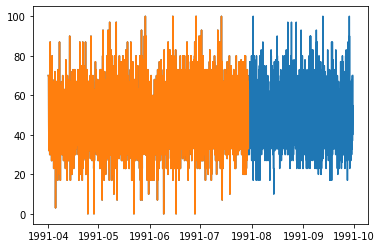

In [14]:
plt.plot(EB00)
plt.plot(EB00_train)

In [24]:
EB00_train_T=EB00_train.T
EB00_train_noisy = pd.DataFrame(np.repeat(EB00_train_T.values,100,axis=0), columns=EB00_train_T.columns)

EB00_train_noisy=EB00_train_noisy.iloc[:,51:]
EB00_train_noisy

time,1991-04-01 17:00:00,1991-04-01 17:20:00,1991-04-01 17:40:00,1991-04-01 18:00:00,1991-04-01 18:20:00,1991-04-01 18:40:00,1991-04-01 19:00:00,1991-04-01 19:20:00,1991-04-01 19:40:00,1991-04-01 20:00:00,...,1991-07-29 21:00:00,1991-07-29 21:20:00,1991-07-29 21:40:00,1991-07-29 22:00:00,1991-07-29 22:20:00,1991-07-29 22:40:00,1991-07-29 23:00:00,1991-07-29 23:20:00,1991-07-29 23:40:00,1991-07-30 00:00:00
0,63,57,40,42,50,42,45,57,45,53,...,43,37,57,63,43,37,37,33,33,33
1,63,57,40,42,50,42,45,57,45,53,...,43,37,57,63,43,37,37,33,33,33
2,63,57,40,42,50,42,45,57,45,53,...,43,37,57,63,43,37,37,33,33,33
3,63,57,40,42,50,42,45,57,45,53,...,43,37,57,63,43,37,37,33,33,33
4,63,57,40,42,50,42,45,57,45,53,...,43,37,57,63,43,37,37,33,33,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,63,57,40,42,50,42,45,57,45,53,...,43,37,57,63,43,37,37,33,33,33
96,63,57,40,42,50,42,45,57,45,53,...,43,37,57,63,43,37,37,33,33,33
97,63,57,40,42,50,42,45,57,45,53,...,43,37,57,63,43,37,37,33,33,33
98,63,57,40,42,50,42,45,57,45,53,...,43,37,57,63,43,37,37,33,33,33


In [25]:
EB00_train_T

time,1991-04-01 00:00:00,1991-04-01 00:20:00,1991-04-01 00:40:00,1991-04-01 01:00:00,1991-04-01 01:20:00,1991-04-01 01:40:00,1991-04-01 02:00:00,1991-04-01 02:20:00,1991-04-01 02:40:00,1991-04-01 03:00:00,...,1991-07-29 21:00:00,1991-07-29 21:20:00,1991-07-29 21:40:00,1991-07-29 22:00:00,1991-07-29 22:20:00,1991-07-29 22:40:00,1991-07-29 23:00:00,1991-07-29 23:20:00,1991-07-29 23:40:00,1991-07-30 00:00:00
congestion,70,70,70,70,70,70,70,70,70,70,...,43,37,57,63,43,37,37,33,33,33


In [26]:
EB00_train_pure=pd.DataFrame(columns=EB00_train_T.columns)
for window in range(2,52):#SMA and EMA 
    rolling_mean = talib.SMA(EB00_train['congestion'],timeperiod=window)
    EB00_train_pure=pd.concat([EB00_train_pure, pd.DataFrame(rolling_mean).T],ignore_index=True)
for window in range(2,52):#SMA and EMA
    ema_mean =  talib.EMA(EB00_train['congestion'],timeperiod=window)
    EB00_train_pure=pd.concat([EB00_train_pure, pd.DataFrame(ema_mean).T],ignore_index=True)
EB00_train_pure=EB00_train_pure.iloc[:,51:]#.shift(periods=1, freq=None, axis=1)
EB00_train_pure

time,1991-04-01 17:00:00,1991-04-01 17:20:00,1991-04-01 17:40:00,1991-04-01 18:00:00,1991-04-01 18:20:00,1991-04-01 18:40:00,1991-04-01 19:00:00,1991-04-01 19:20:00,1991-04-01 19:40:00,1991-04-01 20:00:00,...,1991-07-29 21:00:00,1991-07-29 21:20:00,1991-07-29 21:40:00,1991-07-29 22:00:00,1991-07-29 22:20:00,1991-07-29 22:40:00,1991-07-29 23:00:00,1991-07-29 23:20:00,1991-07-29 23:40:00,1991-07-30 00:00:00
0,53.0,60.0,48.5,41.0,46.0,46.0,43.5,51.0,51.0,49.0,...,46.5,40.0,47.0,60.0,53.0,40.0,37.0,35.0,33.0,33.0
1,55.333333,54.333333,53.333333,46.333333,44.0,44.666667,45.666667,48.0,49.0,51.666667,...,45.0,43.333333,45.666667,52.333333,54.333333,47.666667,39.0,35.666667,34.333333,33.0
2,52.25,55.75,50.75,50.5,47.25,43.5,44.75,48.5,47.25,50.0,...,43.0,43.0,46.75,50.0,50.0,50.0,45.0,37.5,35.0,34.0
3,51.8,53.2,52.6,49.0,50.4,46.2,43.8,47.2,47.8,48.4,...,43.0,41.8,45.8,50.0,48.6,47.4,47.4,42.6,36.6,34.6
4,51.833333,52.666667,51.0,50.833333,49.166667,49.0,46.0,46.0,46.833333,48.666667,...,43.0,42.0,44.333333,48.666667,48.833333,46.666667,45.666667,45.0,41.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,54.326521,54.437916,53.836336,53.343156,53.203858,52.73703,52.414654,52.60571,52.288805,52.318439,...,48.660841,48.174972,48.542682,49.14507,48.889026,48.39365,47.918914,47.297293,46.701572,46.130673
96,54.418272,54.523649,53.930847,53.443873,53.303307,52.841948,52.521868,52.704649,52.390174,52.415064,...,48.660196,48.18427,48.544096,49.134133,48.88376,48.398708,47.933455,47.323926,46.739276,46.178489
97,54.628236,54.723106,54.134182,53.648815,53.502862,53.042748,52.721038,52.892196,52.576508,52.593448,...,48.657992,48.191672,48.544006,49.122245,48.877356,48.402261,47.946171,47.348324,46.774391,46.223415
98,54.529273,54.626165,54.05259,53.579939,53.439549,52.990939,52.677569,52.847076,52.539348,52.557413,...,48.654365,48.197331,48.542534,49.109494,48.869906,48.404419,47.957187,47.370631,46.807076,46.265623


## Fit models(ltsm/cnn)

## MinMaxScaler(GSPC)

In [27]:
mm_t = MinMaxScaler()
noise_mm = mm_t.fit_transform(EB00_train_noisy.T).T
pure_mm=mm_t.fit_transform(EB00_train_pure.T).T
print(noise_mm.shape)
print(pure_mm.shape)

(100, 8567)
(100, 8567)


In [28]:
train_pure_mm=np.reshape(pure_mm,(len(pure_mm), len(pure_mm[0]), 1))
train_mm=np.reshape(noise_mm, (len(noise_mm), len(noise_mm[0]), 1))

# convert list to numpy array
X_train_mm = np.asarray(train_mm)
Y_train_mm = np.asarray(train_pure_mm)
X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(X_train_mm, Y_train_mm, test_size=0.2,random_state=0)

## CNN

In [96]:
def set_model_encoding_mm():
    model = Sequential()
    model.add(Conv1D(128, kernel_size=3, activation='tanh', padding='same',input_shape=(None, 1)))
    model.add(Conv1D(32, kernel_size=3,activation='tanh',padding='same'))
    model.add(Conv1D(32, kernel_size=3, activation='tanh', padding='same'))
    model.add(Conv1D(128, kernel_size=3,activation='tanh',padding='same'))
    model.add(Conv1D(1,kernel_size=3,activation='sigmoid', padding='same'))
    model.compile(optimizer='adam' , loss='mse', metrics=['mse'])
    
    return model
modelen_mm = set_model_encoding_mm()
modelen_mm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, None, 128)         512       
                                                                 
 conv1d_21 (Conv1D)          (None, None, 32)          12320     
                                                                 
 conv1d_22 (Conv1D)          (None, None, 32)          3104      
                                                                 
 conv1d_23 (Conv1D)          (None, None, 128)         12416     
                                                                 
 conv1d_24 (Conv1D)          (None, None, 1)           385       
                                                                 
Total params: 28,737
Trainable params: 28,737
Non-trainable params: 0
_________________________________________________________________


In [97]:
callback = EarlyStopping(monitor='loss', patience=10)
history_mm = modelen_mm.fit(X_train_mm, Y_train_mm, validation_data = (X_val_mm, Y_val_mm), epochs=400, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/400
3/3 [==============================] - 2s 478ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 2/400
3/3 [==============================] - 1s 432ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 3/400
3/3 [==============================] - 1s 469ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0135 - val_mse: 0.0135
Epoch 4/400
3/3 [==============================] - 2s 499ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 5/400
3/3 [==============================] - 1s 451ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 6/400
3/3 [==============================] - 1s 457ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 7/400
3/3 [==============================] - 2s 486ms/step - loss: 0.0138 - mse: 0.0138 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 8/400
3/3 [==============================] - 1s 458ms/step - loss: 0.0133 - m

In [99]:
modelen_mm.save_weights('model_weights_mm.h5', overwrite=True)  

In [100]:
modelen_mm.load_weights('model_weights_mm.h5') 

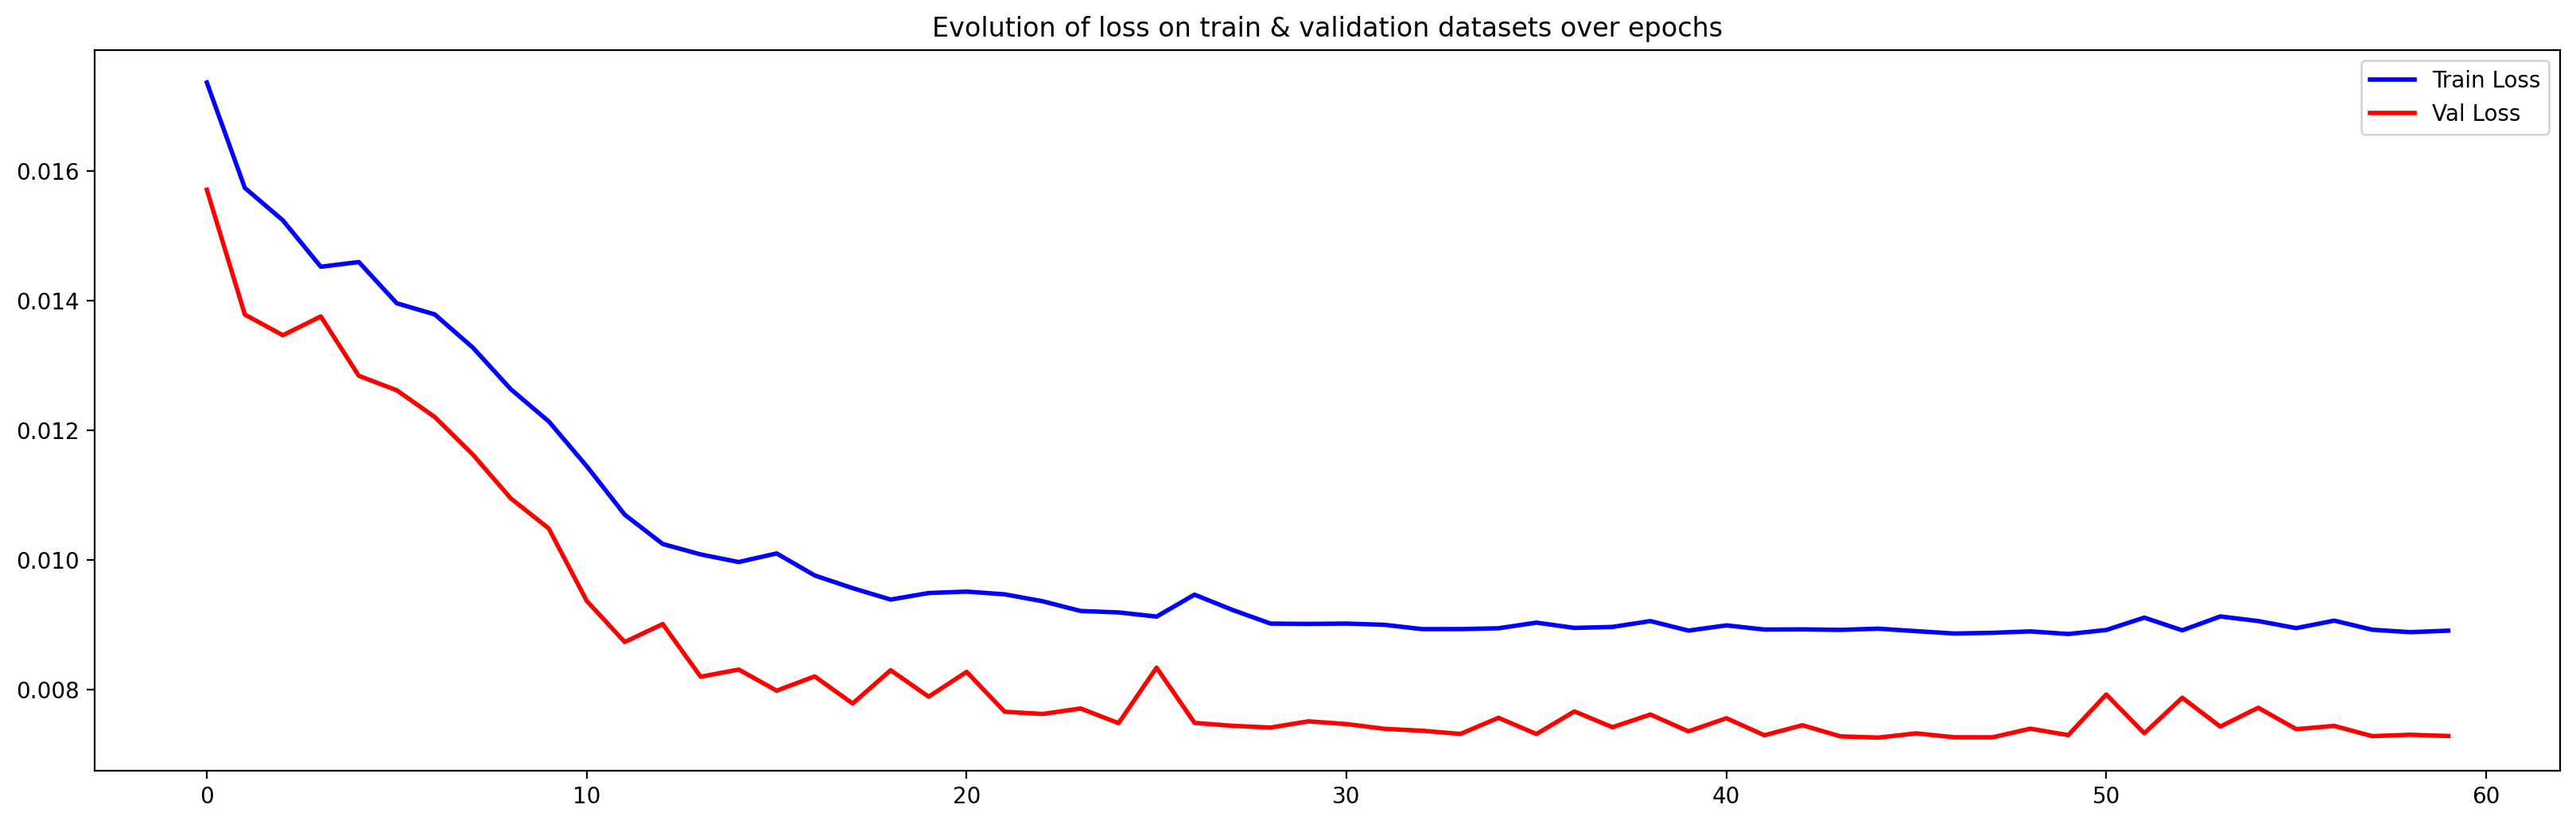

In [98]:
# Check how loss & mae went down
epoch_loss = history_mm.history['loss']
epoch_val_loss = history_mm.history['val_loss']
epoch_mse = history_mm.history['mse']
epoch_val_mse = history_mm.history['val_mse']

plt.figure(figsize=(20,6),dpi=200)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')


plt.show()

In [39]:
EB00_test.shape

(4441, 1)

1/1 [==============================] - 0s 66ms/step


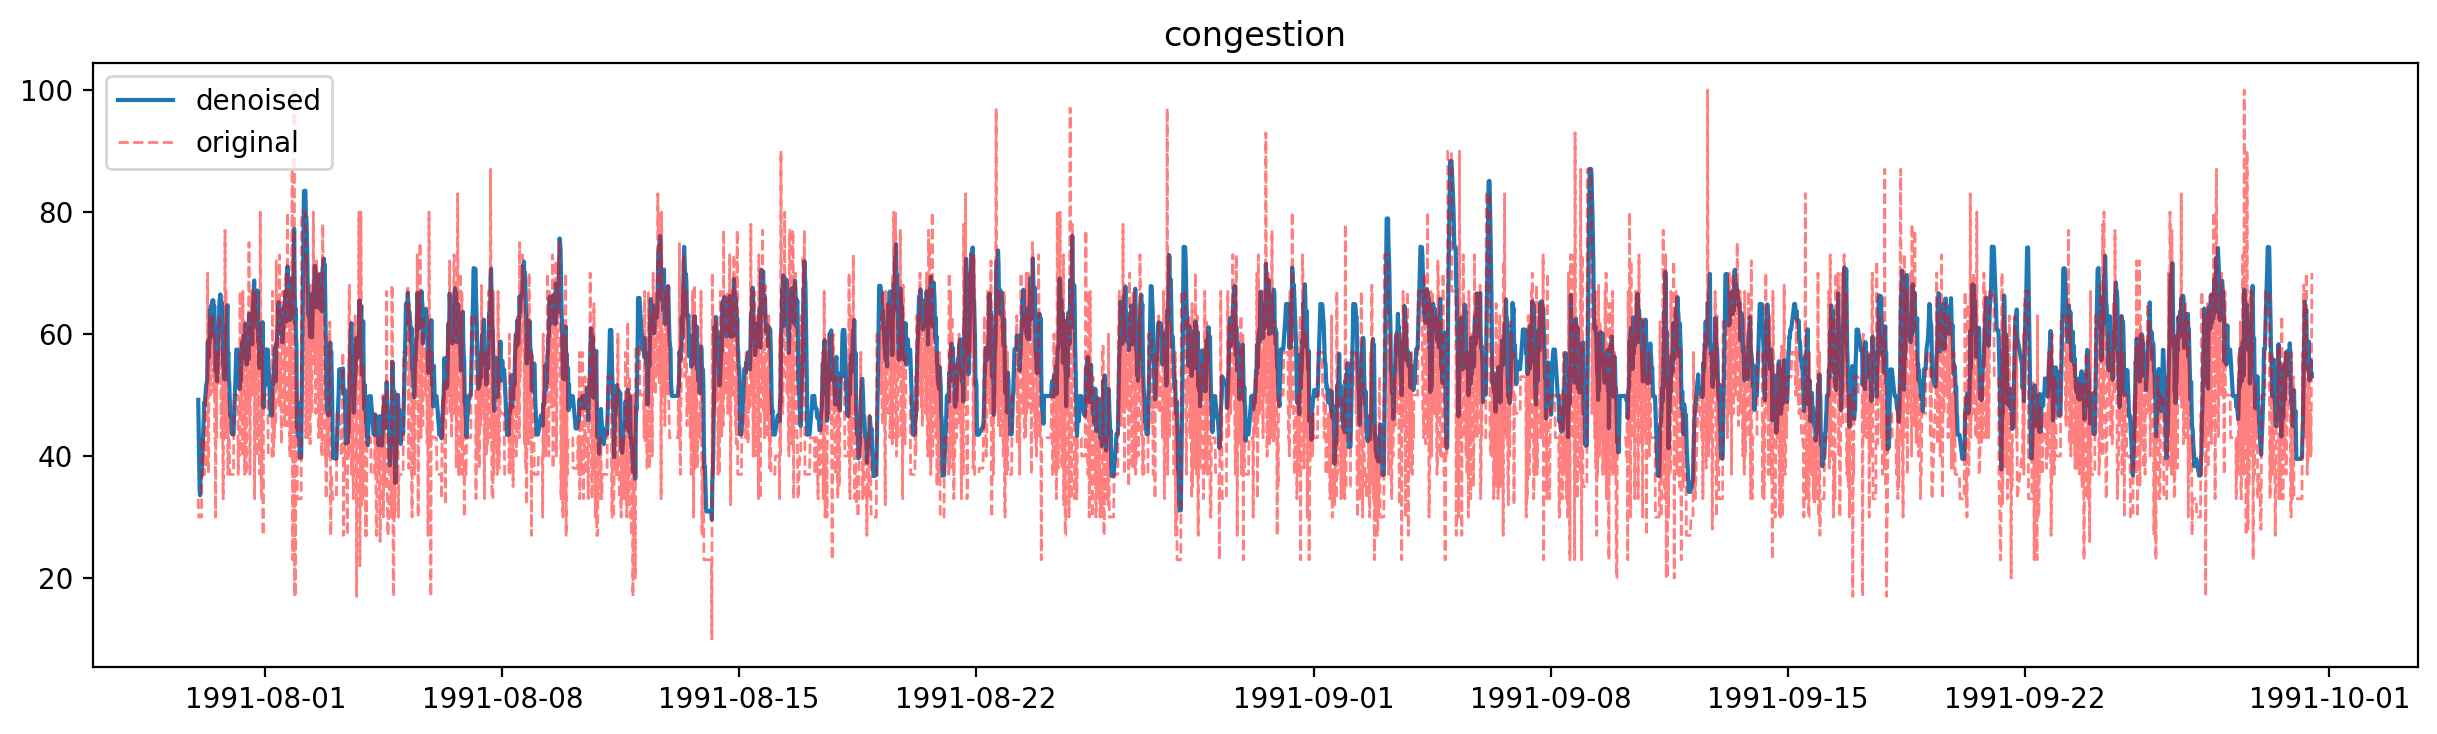

In [101]:
mm_t = MinMaxScaler()
noise_mm_T=mm_t.fit_transform(EB00_test)
Y_test_mm_cnn = modelen_mm.predict(noise_mm_T.T)
Y_test_mm_cnn=Y_test_mm_cnn.reshape((len(EB00_test),1))
pure_mm_cnn = mm_t.inverse_transform(Y_test_mm_cnn)
pure_mm_cnn=pd.DataFrame(pure_mm_cnn,columns=['congestion'],index=EB00_test.index)
plt.figure(figsize=(15,4),dpi=200)
plt.plot(pure_mm_cnn)
plt.plot(EB00_test,color='r',linestyle='--',linewidth=1,alpha=0.5)
plt.title('congestion')
plt.legend(['denoised', 'original'], loc='upper left')

In [102]:
original=EB00_test

In [103]:
def features(dataset):
    ret_dataset=pd.DataFrame(index=dataset.index)
    for i in range(2,52,1):
        window = i
        # Volatility
        ret_dataset[str('SMA'+str(i))] = talib.SMA(dataset['congestion'],timeperiod=window).shift(1)
        ret_dataset[str('EMA'+str(i))] = talib.EMA(dataset['congestion'],timeperiod=window).shift(1)
        ret_dataset[str('STDDEV'+str(i))] = talib.STDDEV(dataset['congestion'],timeperiod=window).shift(1)
        ret_dataset[str('Lag'+str(i))] = dataset['congestion'].shift(i)
    return ret_dataset

In [114]:
from sklearn.model_selection import TimeSeriesSplit

In [117]:
tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(pure_mm_cnn):
     print("TRAIN:", len(train_index), "TEST:", len(test_index))

TRAIN: 741 TEST: 740
TRAIN: 1481 TEST: 740
TRAIN: 2221 TEST: 740
TRAIN: 2961 TEST: 740
TRAIN: 3701 TEST: 740


In [113]:
pure_mm_cnn_fea=features(pure_mm_cnn)
pure_mm_cnn_fea=pure_mm_cnn_fea.iloc[51:]
X_train, X_test, Y_train, Y_test = train_test_split(pure_mm_cnn_fea, original.iloc[51:], test_size=0.2,shuffle=False)

model = xgb.XGBRegressor()
his=model.fit(X_train,Y_train)

test_predict=model.predict(X_test)
train_predict = model.predict(X_train)

msetest=mean_squared_error(Y_test,test_predict)
msetrain=mean_squared_error(Y_train,train_predict)

print(msetest)
print(msetrain)

142.37728241962955
2.9096800600268136


In [112]:
original_fea=features(original)
original_fea=original_fea.iloc[51:]
X_train, X_test, Y_train, Y_test = train_test_split(original_fea, original.iloc[51:], test_size=0.2)

model = xgb.XGBRegressor()
his=model.fit(X_train,Y_train)

test_predict=model.predict(X_test)
train_predict = model.predict(X_train)

msetest=mean_squared_error(Y_test,test_predict)
msetrain=mean_squared_error(Y_train,train_predict)

print(msetest)
print(msetrain)

135.58257313854978
2.6761762490722907


In [124]:
pure_mm_cnn_whole=pure_mm_cnn_fea.copy()
pure_mm_cnn_whole['target']=original.iloc[51:]

In [127]:
pure_mm_cnn_whole.to_csv('pure_mm_cnn_whole.csv')

In [128]:
original_whole=original_fea.copy()
original_whole['target']=original.iloc[51:]
original_whole.to_csv('original_whole.csv')

In [121]:
original_fea.to_csv('original_fea.csv')
pure_mm_cnn_fea.to_csv('pure_mm_cnn_fea.csv')
original.to_csv('original.csv')

In [ ]:
max_depth=5,
learning_rate=0.1,
n_estimators=100,
gamma=0,
min_child_weight=1,
subsample=0.8,
colsample_bytree=0.8,
colsample_bylevel=1,
reg_alpha=0,
reg_lambda=1